<a href="https://colab.research.google.com/github/ErmakovSemen/diploma/blob/main/diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Classes


In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm import tqdm
from scipy.stats import binom

class Assessor:
    def __init__(self, id, confusion_matrix):
        self.id = id
        self.confusion_matrix = confusion_matrix.copy()
        self.history = []

    def rate(self, true_label):
        c = self.confusion_matrix
        if true_label == 1:
            p = c['TP'] / (c['TP'] + c['FN'])
        else:
            p = c['FP'] / (c['FP'] + c['TN'])
        return int(np.random.rand() < p)

    def p_truth_given_response(self, response, prior=0.5):
        c = self.confusion_matrix
        TP, FP, TN, FN = c['TP'], c['FP'], c['TN'], c['FN']
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        if response == 1:
            numer = tpr * prior
            denom = tpr * prior + fpr * (1 - prior)
        else:
            numer = (1 - tpr) * prior
            denom = (1 - tpr) * prior + (1 - fpr) * (1 - prior)
        return numer / denom if denom > 0 else prior

    def theory_metrics(self):
        c = self.confusion_matrix
        TP, FP, TN, FN = c['TP'], c['FP'], c['TN'], c['FN']
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        return {'precision': precision, 'recall': recall, 'f1': f1, 'fpr': fpr}

    @staticmethod
    def confusion_matrix_from_f1(target_f1, pr_coeff=1):
        recall = target_f1 * (pr_coeff + 1) / (2 * pr_coeff)
        precision = pr_coeff * recall
        if not (0 < recall <= 1 and 0 < precision <= 1):
            return None
        TP = recall
        FN = 1 - recall
        FP = TP / precision - TP if precision > 0 else 1
        TN = 1 - FP
        if FP < 0 or FP > 1 or TN < 0 or TN > 1:
            return None
        return {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

    @staticmethod
    def generate_noisy_confusion_matrix_from_f1(target_f1, pr_coeff=1, noise_std=0.01, max_tries=5):
        for _ in range(max_tries):
            base = Assessor.confusion_matrix_from_f1(target_f1, pr_coeff=pr_coeff)
            if base is None: continue
            cmatrix = {
                k: np.clip(base[k] + np.random.normal(0, noise_std), 0.01, 0.99)
                for k in base
            }
            # Нормировка
            pos_sum = cmatrix['TP'] + cmatrix['FN']
            neg_sum = cmatrix['FP'] + cmatrix['TN']
            if pos_sum <= 0 or neg_sum <= 0: continue
            cmatrix['TP'] /= pos_sum
            cmatrix['FN'] /= pos_sum
            cmatrix['FP'] /= neg_sum
            cmatrix['TN'] /= neg_sum
            if all(0 < v < 1 for v in cmatrix.values()):
                return cmatrix
        return None

    @classmethod
    def generate_diverse_assessors(cls, n, target_f1, pr_coeff=1, noise_std=0.01):
        assessors = []
        tries = 0
        max_total_tries = 10 * n
        while len(assessors) < n and tries < max_total_tries:
            cmat = cls.generate_noisy_confusion_matrix_from_f1(target_f1, pr_coeff, noise_std)
            tries += 1
            if cmat is not None:
                assessors.append(cls(len(assessors), cmat))
        if len(assessors) < n:
            print(f"[WARN] Only {len(assessors)} of {n} assessors generated.")
        mean_emp_f1 = np.mean([a.theory_metrics()['f1'] for a in assessors]) if assessors else 0.
        return assessors, mean_emp_f1


# --- DataSimulator ---

class DataSimulator:
    def __init__(self, config, assessors=None):
        self.config = config
        self.assessors = assessors if assessors is not None else self._create_assessors()

    def _create_assessors(self):
        p = self.config["assessors"]
        # Допускаем только diverse_assessors-by-F1 способ
        if 'target_f1' in p and 'pr_coeff' in p:
            assessors = Assessor.generate_diverse_assessors(
                p["total_count"],
                target_f1=p["target_f1"],
                pr_coeff=p["pr_coeff"],
                noise_std=p.get("noise", 0.01)
            )[0]
            # print(assessors)
            return assessors
        elif 'matrix' in p:
            # Для "фиксированной" толпы без разброса
            n = p["total_count"]
            cmatrix = p["matrix"]
            return [Assessor(i, cmatrix) for i in range(n)]
        else:
            raise ValueError("Assessor config must contain 'matrix' или target_f1 & pr_coeff")

    def simulate_binary_tasks(self, debug=False):
        group_probs = {
            "A": self.config["experiment"]["prevalence"],
            "B": self.config["experiment"]["prevalence"] + self.config["experiment"]["effect_size"]
        }
        n_tasks = self.config["experiment"]["sample_size"]
        n_assessors = self.config["assessors"]["per_task_count"]
        tasks_by_group = {'A': [], 'B': []}
        n_a = n_tasks // 2
        n_b = n_tasks - n_a
        for group, n in zip(['A', 'B'], [n_a, n_b]):
            for _ in range(n):
                p_true = group_probs[group]
                true_label = int(np.random.rand() < p_true)
                chosen = np.random.choice(self.assessors, size=n_assessors, replace=False)
                responses = [(a.rate(true_label), a.id) for a in chosen]
                tasks_by_group[group].append(responses)
        assessors_by_id = {a.id: a for a in self.assessors}
        if debug:
            a_means = [np.mean([resp for resp, aid in t]) for t in tasks_by_group['A']]
            b_means = [np.mean([resp for resp, aid in t]) for t in tasks_by_group['B']]
            print(f"[DataSimulator] mean(A)={np.mean(a_means):.3f}, mean(B)={np.mean(b_means):.3f}, diff={np.mean(b_means) - np.mean(a_means):.3f}")
        return tasks_by_group, assessors_by_id


def poisson_binomial_variance(ps):
    N = len(ps)
    return np.sum([p * (1 - p) for p in ps]) / N**2

def get_ps_for_label(assessors, true_label):
    ps = []
    for a in assessors:
        c = a.confusion_matrix
        if true_label == 1:
            p = c['TP'] / (c['TP'] + c['FN'])
        else:
            p = c['FP'] / (c['FP'] + c['TN'])
        ps.append(p)
    return ps

def pooled_poibin_variance(assessors, prevalence=0.5):
    var1 = poisson_binomial_variance(get_ps_for_label(assessors, true_label=1))
    var0 = poisson_binomial_variance(get_ps_for_label(assessors, true_label=0))
    return prevalence * var1 + (1 - prevalence) * var0

def pooled_poibin_variance(assessors, prevalence=0.5):
    if isinstance(assessors, tuple):
        assessors = assessors[0]
    elif isinstance(assessors, list) and len(assessors) > 0 and isinstance(assessors[0], list):
        assessors = [a for group in assessors for a in group]
    var1 = poisson_binomial_variance([a.theory_metrics()['recall'] for a in assessors])
    var0 = poisson_binomial_variance([a.theory_metrics()['fpr'] for a in assessors])
    return prevalence * var1 + (1 - prevalence) * var0



class AssessorProbabilisticAggregator:
    @staticmethod
    def aggregate_task(responses, assessors_by_id, prior=0.5, debug=False):
        P_truth = []
        for resp, aid in responses:
            a = assessors_by_id[aid]
            p = a.p_truth_given_response(resp, prior)
            P_truth.append(p)
        mean_p = np.mean(P_truth) if P_truth else 0.0
        var_p = np.mean([p*(1-p) for p in P_truth]) / (len(P_truth) if len(P_truth) else 1)
        if debug:
            print(f"[ProbAgg] mean_p={mean_p:.3f}, var_p={var_p:.3f}, P_truth={P_truth}")
        return mean_p, var_p



def poisson_binomial_majority_variance(ps):
    """
    Вернёт variance для majority vote на задаче (Bernoulli Poisson-binomial).
    """
    N = len(ps)
    pmf = np.zeros(N + 1)
    pmf[0] = 1.0
    for p in ps:
        pmf[1:] = pmf[1:] * (1 - p) + pmf[:-1] * p
        pmf[0] *= (1 - p)
    threshold = N // 2 + 1
    q_maj = pmf[threshold:].sum()
    return q_maj * (1 - q_maj)

def majority_var(ps):
    N = len(ps)
    pmf = np.zeros(N + 1)
    pmf[0] = 1.0
    for p in ps:
        pmf[1:] = pmf[1:] * (1 - p) + pmf[:-1] * p
        pmf[0] *= (1 - p)
    threshold = N // 2 + 1
    q_maj = pmf[threshold:].sum()
    return q_maj * (1 - q_maj)

def get_ps(task, assessors_by_id, is_pos):
    return [
        (assessors_by_id[aid].theory_metrics()['recall'] if is_pos else assessors_by_id[aid].theory_metrics()['fpr'])
        for _, aid in task
    ]


class VarianceEstimator:
    @staticmethod
    def classic(tasks_by_group, *a, **k):
        group_stats = {}
        for group in ['A', 'B']:
            majority = [
                int(np.sum([label for label, _ in task]) >= (len(task) // 2 + 1))
                for task in tasks_by_group[group]
            ]
            group_stats[group] = {'mean': np.mean(majority), 'var': np.var(majority, ddof=1)}
        return {
            'var_a': group_stats['A']['var'],
            'var_b': group_stats['B']['var'],
            'mean_a': group_stats['A']['mean'],
            'mean_b': group_stats['B']['mean']
        }

    @staticmethod
    def probabilistic(tasks_by_group, assessors_by_id, prior=0.5):
        group_stats = {}
        for group in ['A', 'B']:
            # Mean aggregation per task (probabilistic mean)
            means = [
                np.mean([label for label, _ in task])  # simple arithmetic mean over all answers
                for task in tasks_by_group[group]
            ]
            group_stats[group] = {'mean': np.mean(means), 'var': np.var(means, ddof=1)}
        return {
            'var_a': group_stats['A']['var'],
            'var_b': group_stats['B']['var'],
            'mean_a': group_stats['A']['mean'],
            'mean_b': group_stats['B']['mean']
        }


    @staticmethod
    def probabilistic_pooled(tasks_by_group, assessors_by_id, prior=0.5):
        group_stats = {}
        for group in ['A', 'B']:
            ps_list = []
            for task in tasks_by_group[group]:
                ps = get_ps(task, assessors_by_id, True if prior >= 0.5 else False)
                ps_list.extend(ps)
            var = majority_var(ps_list)
            mean_major_list = [
                int(np.sum([label for label, _ in task]) >= (len(task) // 2 + 1))
                for task in tasks_by_group[group]
            ]
            mean_group = np.mean(mean_major_list)
            group_stats[group] = {'mean': mean_group, 'var': var}
        return {
            'var_a': group_stats['A']['var'],
            'var_b': group_stats['B']['var'],
            'mean_a': group_stats['A']['mean'],
            'mean_b': group_stats['B']['mean']
        }

    @staticmethod
    def probabilistic_pooled_taskwise(tasks_by_group, assessors_by_id, prior=0.5):
        group_stats = {}
        for group in ['A', 'B']:
            var_list = []
            for task in tasks_by_group[group]:
                ps = get_ps(task, assessors_by_id, True if prior >= 0.5 else False)
                var = majority_var(ps)
                var_list.append(var)
            var_group = np.mean(var_list)
            mean_major_list = [
                int(np.sum([label for label, _ in task]) >= (len(task) // 2 + 1))
                for task in tasks_by_group[group]
            ]
            mean_group = np.mean(mean_major_list)
            group_stats[group] = {'mean': mean_group, 'var': var_group}
        return {
            'var_a': group_stats['A']['var'],
            'var_b': group_stats['B']['var'],
            'mean_a': group_stats['A']['mean'],
            'mean_b': group_stats['B']['mean']
        }

def single_simulation(config, prior=0.5, alpha=None, methods=None, assessors_override=None, debug=False):
    if alpha is None:
        alpha = config["experiment"].get("alpha", 0.05)
    if methods is None:
        methods = {
            "classic": VarianceEstimator.classic,
            "probabilistic": VarianceEstimator.probabilistic,
            "probabilistic_pooled": VarianceEstimator.probabilistic_pooled,
            "probabilistic_pooled_taskwise": VarianceEstimator.probabilistic_pooled_taskwise
        }
    has_effect = np.random.rand() > 0.5
    effect_size = config["experiment"]["effect_size"] if has_effect else 0.0
    local_config = {**config, "experiment": {**config["experiment"], "effect_size": effect_size}}
    simulator = DataSimulator(local_config, assessors=assessors_override)
    tasks_by_group, assessors_by_id = simulator.simulate_binary_tasks(debug=debug)
    n_a, n_b = len(tasks_by_group['A']), len(tasks_by_group['B'])
    if n_a < 2 or n_b < 2:
        return []
    res_list = []
    for method_name, method in methods.items():
        try:
            res = method(tasks_by_group, assessors_by_id, prior)
            var_ztest = res['var_a'] / n_a + res['var_b'] / n_b
            se = np.sqrt(var_ztest)
            effect = res['mean_b'] - res['mean_a']
            p_value = 1.0 if se == 0 and effect == 0 else 0.0 if se == 0 else 2 * (1 - norm.cdf(abs(effect/se)))
            out = {
                "method": method_name,
                "p_value": p_value,
                "effect_detected": (p_value < alpha if p_value is not None else None),
                "true_effect": has_effect,
                "mean_diff": effect,
                "var_a": res['var_a'],
                "var_b": res['var_b'],
                "var_ztest": var_ztest,
                "status": "success"
            }
            res_list.append(out)
        except Exception as e:
            print(f"[ERROR] Метод {method_name} упал! Ошибка: {e}")
            if debug: print(f"[{method_name}] failed: {e}")
            res_list.append({
                "method": method_name, "p_value": None, "effect_detected": None, "true_effect": has_effect,
                "mean_diff": None, "var_a": None, "var_b": None, "var_ztest": None, "status": f"failed: {e}"
            })
    return res_list

class Plotter:
    @staticmethod
    def plot_f1_vs_param(df, param_name='mean_f1_assessor', methods=None, title=None):
        if methods is None:
            methods = df['method'].unique()
        plt.figure(figsize=(8, 5))
        for method in methods:
            part = df[df['method'] == method]
            plt.plot(part[param_name], part['f1_test'], '-o', label=method.capitalize())
        plt.xlabel(param_name)
        plt.ylabel('F1-score теста')
        if title:
            plt.title(title)
        else:
            plt.title(f'F1-score теста vs {param_name}')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_f1_from_summary(summary, title="F1-score теста по методу"):
        if not summary:
            print("Нет данных для графика summary.")
            return
        methods = list(summary.keys())
        xvals = methods
        yvals = [summary[m]['f1_test'] for m in methods]
        plt.figure(figsize=(8, 5))
        plt.bar(xvals, yvals)
        plt.ylabel('F1-score теста')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_summary_vs_param(df, param_name='mean_f1_assessor', methods=None):
        if methods is None:
            methods = df['method'].unique()
        fig, ax = plt.subplots(1, 1, figsize=(9, 5))
        for method in methods:
            part = df[df['method'] == method]
            ax.plot(part[param_name], part['f1_test'], '-o', label=f'{method.capitalize()} F1')
            # Можно добавить ещё power/mean_effect, если решила считать
            # ax.plot(part[param_name], part['power'], '--', label=f'{method.capitalize()} Power')
            # ax.plot(part[param_name], part['mean_effect'], ':', label=f'{method.capitalize()} Effect')
        ax.set_xlabel(param_name)
        ax.set_ylabel('Метрика')
        ax.set_title(f'Метрики теста vs {param_name}')
        ax.legend()
        ax.grid()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_pvalue_histogram(pvals, methods=None, bins=20):
        plt.figure(figsize=(8,5))
        if methods is None:
            methods = list(pvals.keys())
        for method in methods:
            plt.hist(pvals[method], bins=np.linspace(0, 1, bins+1),
                     alpha=0.5, density=True, label=method.capitalize())
        plt.axhline(1, color='black', linestyle='--', label='Uniform')
        plt.xlabel('p-value')
        plt.ylabel('Density')
        plt.title('Гистограмма p-value')
        plt.legend()
        plt.tight_layout()
        plt.show()


def simulate_fraction_zeros_mv(assessors, prevalence=0.5, n_experiments=500, n_tasks_per_exp=100):
    N = len(assessors)
    results = []
    for _ in range(n_experiments):
        zeros = 0
        for _ in range(n_tasks_per_exp):
            true_label = int(np.random.rand() < prevalence)
            responses = np.array([a.rate(true_label) for a in assessors])
            maj = int(np.sum(responses) >= (N // 2 + 1))
            if maj == 0:
                zeros += 1
        results.append(zeros / n_tasks_per_exp)
    return np.array(results)


# -- Теоретическая вероятность majority==0 (по theory_metrics assessora)
def poisson_binomial_pmf(ps):
    N = len(ps)
    pmf = np.zeros(N + 1)
    pmf[0] = 1.0
    for p in ps:
        pmf[1:] = pmf[1:] * (1 - p) + pmf[:-1] * p
        pmf[0] *= (1 - p)
    return pmf

def theoretical_prob_majority_zero(assessors, prevalence=0.5):
    ps_1 = [a.theory_metrics()['recall'] for a in assessors]
    ps_0 = [a.theory_metrics()['fpr'] for a in assessors]
    N = len(ps_1)
    thresh = N // 2 + 1
    pmf1 = poisson_binomial_pmf(ps_1)
    pmf0 = poisson_binomial_pmf(ps_0)
    q1 = np.sum(pmf1[:thresh])  # P(majority==0|истина=1)
    q0 = np.sum(pmf0[:thresh])  # P(majority==0|истина=0)
    return prevalence * q1 + (1 - prevalence) * q0


def aggregate_majority_vote_experiments(assessors, true_label=1, n_experiments=1000, n_trials_per_exp=100, agg_func='majority'):
    """
    Для assessors/true_label моделирует n_experiments раз,
    каждый раз делая n_trials_per_exp агрегаций голосования.
    Возвращает: массив средних результатов по эксп. (или долей 0).
    """
    N = len(assessors)
    experiment_means = []
    for _ in range(n_experiments):
        votes = []
        for _ in range(n_trials_per_exp):
            responses = np.array([a.rate(true_label) for a in assessors])
            if agg_func == 'majority':
                value = int(np.sum(responses) >= (N // 2 + 1))
            elif agg_func == 'mean':
                value = np.mean(responses)
            votes.append(value)
        experiment_means.append(np.mean(votes))
    return np.array(experiment_means)


def expected_mean(assessors, true_label):
    ps = []
    for a in assessors:
        c = a.confusion_matrix
        if true_label == 1:
            p = c['TP'] / (c['TP'] + c['FN'])
        else:
            p = c['FP'] / (c['FP'] + c['TN'])
        ps.append(p)
    return np.mean(ps)




# Main Logic


In [ ]:
def single_simulation(
    config, prior=0.5, alpha=None, methods=None, assessors_override=None, debug=False
):
    if alpha is None:
        alpha = config["experiment"].get("alpha", 0.05)
    if methods is None:
        methods = {
            "classic": VarianceEstimator.classic,
            "probabilistic": VarianceEstimator.probabilistic,
            "probabilistic_pooled": VarianceEstimator.probabilistic_pooled,
            "probabilistic_pooled_taskwise": VarianceEstimator.probabilistic_pooled_taskwise
        }
    has_effect = np.random.rand() > 0.5
    effect_size = config["experiment"]["effect_size"] if has_effect else 0.0
    local_config = {**config, "experiment": {**config["experiment"], "effect_size": effect_size}}
    simulator = DataSimulator(local_config, assessors=assessors_override)
    tasks_by_group, assessors_by_id = simulator.simulate_binary_tasks(debug=debug)
    n_a, n_b = len(tasks_by_group['A']), len(tasks_by_group['B'])
    if n_a < 2 or n_b < 2: return []
    res_list = []
    for method_name, method in methods.items():
        try:
            res = method(tasks_by_group, assessors_by_id, prior)
            var_ztest = res['var_a'] / n_a + res['var_b'] / n_b
            se = np.sqrt(var_ztest) if var_ztest >= 0 and np.isfinite(var_ztest) else 0.0
            effect = res['mean_b'] - res['mean_a']
            p_value = 1.0 if se == 0 and effect == 0 else 0.0 if se == 0 else 2 * (1 - norm.cdf(abs(effect/se)))
            out = {
                "method": method_name,
                "p_value": p_value,
                "effect_detected": (p_value < alpha if p_value is not None else None),
                "true_effect": has_effect,
                "mean_diff": effect,
                "var_a": res['var_a'],
                "var_b": res['var_b'],
                "var_ztest": var_ztest,
                "status": "success"
            }

            if debug:
                print(f"\n[DEBUG SINGLE_SIMULATION] method: {method_name}")
                print(f"  mean_a: {res['mean_a']:.4f}  mean_b: {res['mean_b']:.4f}  mean_diff: {effect:.4f}")
                print(f"  var_a: {res['var_a']:.5f}  var_b: {res['var_b']:.5f}  var_ztest: {var_ztest:.5f}")
                print(f"  se: {se:.5f}  p_value: {p_value:.5f}")

                # For 'probabilistic_pooled_taskwise', show variance per задаче:
                if method_name == "probabilistic_pooled_taskwise":
                    for group in ['A', 'B']:
                        print(f" |   {group} pooled-taskwise var: {res.get(f'var_{group[0]}', float('nan')):.6f}")

                # Majority outcome distribution (per A-группу/задачу) для диагностики
                if method_name.startswith('prob'):
                    majors_a = [
                        int(np.sum([label for label, _ in task]) >= (len(task) // 2 + 1))
                        for task in tasks_by_group['A']
                    ]
                    majors_b = [
                        int(np.sum([label for label, _ in task]) >= (len(task) // 2 + 1))
                        for task in tasks_by_group['B']
                    ]
                    print(f"  majority vote (A): mean={np.mean(majors_a):.4f}, variance={np.var(majors_a):.5f}")
                    print(f"  majority vote (B): mean={np.mean(majors_b):.4f}, variance={np.var(majors_b):.5f}")

            res_list.append(out)
        except Exception as e:
            print(f"[ERROR] Метод {method_name} упал! Ошибка: {e}")
            if debug: print(f"[{method_name}] failed: {e}")
            res_list.append({
                "method": method_name, "p_value": None, "effect_detected": None, "true_effect": has_effect,
                "mean_diff": None, "var_a": None, "var_b": None, "var_ztest": None, "status": f"failed: {e}"
            })
    return res_list

def run_exp(
    config, n_simulations=100, prior=0.5, alpha=None,
    methods=None, assessors_override=None, debug=False, plot=False, plot_param=None
):

    if methods is None:
        methods = {
            "classic": VarianceEstimator.classic,
            "probabilistic": VarianceEstimator.probabilistic,
            "probabilistic_pooled": VarianceEstimator.probabilistic_pooled,
            "probabilistic_pooled_taskwise": VarianceEstimator.probabilistic_pooled_taskwise,
        }
    all_results = []
    for sim in range(n_simulations):
        sim_results = single_simulation(
            config, prior=prior, alpha=alpha,
            methods=methods, assessors_override=assessors_override, debug=debug
        )
        for result in sim_results:
            result['simulation'] = sim
            if 'method' not in result:
                result['method'] = 'classic'
            all_results.append(result)
    df_results = pd.DataFrame(all_results)
    summary = {}
    for method in df_results['method'].unique():
        mdata = df_results[df_results['method'] == method]
        good = mdata[mdata['status'] == 'success']
        if len(good) < 1:
            summary[method] = {k: None for k in ['power', 'fpr', 'success_rate', 'mean_effect', 'f1_test']}
            continue
        has_true = (good['true_effect'] == True).sum() > 0
        has_false = (good['true_effect'] == False).sum() > 0
        power = good[good['true_effect'] == True]['effect_detected'].mean() if has_true else None
        fpr = good[good['true_effect'] == False]['effect_detected'].mean() if has_false else None
        y_true = good['true_effect'].astype(int).values
        y_pred = good['effect_detected'].fillna(False).astype(bool).astype(int).values
        f1_t = f1_score(y_true, y_pred, zero_division=0) if len(np.unique(y_true)) > 1 and len(np.unique(y_pred)) > 1 else 0.0
        summary[method] = {
            "power": power,
            "fpr": fpr,
            "success_rate": len(good) / n_simulations,
            "mean_effect": good['mean_diff'].mean() if good['mean_diff'].notna().any() else None,
            "f1_test": f1_t
        }
    if plot and summary:
        Plotter.plot_f1_from_summary_plotly(summary)
    return df_results, summary




def universal_sweep(
    param_grid, param_name,
    n_assessors=30, n_simulations=30,
    base_config=None, sweep_type='f1', pr_coeff=1,
    debug=False, plot=False, methods=None, metrics=('f1_test', 'power', 'fpr', 'variance', 'mean_effect')
):
    import pandas as pd
    all_records = []
    for param_val, ass_kwargs in tqdm(param_grid, desc=f'Sweeping {param_name}'):
        assessors, _ = Assessor.generate_diverse_assessors(
            n_assessors,
            target_f1=ass_kwargs.get('target_f1', param_val),
            pr_coeff=ass_kwargs.get('pr_coeff', pr_coeff),
            noise_std=ass_kwargs.get('noise_std', 0.01)
        )
        if len(assessors) < n_assessors // 2:
            if debug:
                print(f"[WARN] Only {len(assessors)} of {n_assessors} assessors generated at {param_name}={param_val}")
            continue
        metrics_arr = [a.theory_metrics() for a in assessors]
        mean_f1 = np.mean([m['f1'] for m in metrics_arr])
        mean_prec = np.mean([m['precision'] for m in metrics_arr])
        mean_rec = np.mean([m['recall'] for m in metrics_arr])
        mean_fpr = np.mean([m['fpr'] for m in metrics_arr])
        config = base_config.copy()
        config["assessors"]["total_count"] = n_assessors
        config["assessors"]["per_task_count"] = ass_kwargs.get('per_task_count', 5)
        df_results, summary = run_exp(
            config, n_simulations=n_simulations,
            assessors_override=assessors, methods=methods, plot=False, debug=False
        )
        for method in (methods or summary.keys()):
            s = summary.get(method, {})
            variance = df_results[df_results["method"] == method]['var_a'].mean() if "var_a" in df_results else None
            record = {
                param_name: param_val,
                'mean_f1_assessor': mean_f1,
                'mean_prec_assessor': mean_prec,
                'mean_rec_assessor': mean_rec,
                'mean_fpr_assessor': mean_fpr,
                'method': method,
            }
            for met in metrics:
                v = s.get(met)
                if v is None and met == "variance":
                    v = variance
                record[met] = v
            all_records.append(record)
            if debug:
                print({**record})
    df = pd.DataFrame(all_records)
    if plot and not df.empty:
        Plotter.plot_f1_vs_param(df, param_name=param_name, methods=df["method"].unique())
    return df


# Tests

In [ ]:
def config_fpr():
    return {
        "experiment": {
            "sample_size": 1000,
            "groups": ["A", "B"],
            "alpha": 0.03,
            "prevalence": 0.25,
            "effect_size": 0.0
        },
        "assessors": {
            "total_count": 40,
            "per_task_count": 12,
            "matrix": {'TP': 0.8, 'FP': 0.2, 'TN': 0.8, 'FN': 0.2}
        }
    }

def config_power():
    return {
        "experiment": {
            "sample_size": 2000,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.25,
            "effect_size": 0.15
        },
        "assessors": {
            "total_count": 60,
            "per_task_count": 12,
            "matrix": {'TP': 0.82, 'FP': 0.18, 'TN': 0.82, 'FN': 0.18}
        }
    }

def config_random_assessors():
    return {
        "experiment": {
            "sample_size": 400,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2
        },
        "assessors": {
            "total_count": 30,
            "per_task_count": 7,
            "matrix": {'TP': 0.5, 'FP': 0.5, 'TN': 0.5, 'FN': 0.5}
        }
    }

def config_informative_assessors():
    return {
        "experiment": {
            "sample_size": 400,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2
        },
        "assessors": {
            "total_count": 30,
            "per_task_count": 7,
            "matrix": {'TP': 1.0, 'FP': 0.0, 'TN': 1.0, 'FN': 0.0}
        }
    }


def config_high_heterogeneity():
    """
    Большой разброс (хаотичность) между assessors:
    каждый имеет индивидуальную матрицу ошибок, с сильным шумом вокруг среднего.
    """
    return {
        "experiment": {
            "sample_size": 1000,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.05
        },
        "assessors": {
            "total_count": 30,
            "per_task_count": 7,
            "matrix": {'TP': 0.7, 'FP': 0.3, 'TN': 0.7, 'FN': 0.3},
            "noise": 0.3  # БОЛЬШОЙ разнос по толпе!
        }
    }


def config_ideal(sample_size=200):
    return {
        "experiment": {
            "sample_size": sample_size,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.22,
            "effect_size": 0.10
        },
        "assessors": {
            "total_count": 40,
            "per_task_count": 12,
            "matrix": {'TP': 1.0, 'FP': 0.0, 'TN': 1.0, 'FN': 0.0}
        }
    }

def config_hard():
    return {
        "experiment": {
            "sample_size": 600,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.08,
            "effect_size": 0.03
        },
        "assessors": {
            "total_count": 60,
            "per_task_count": 10,
            "matrix": {'TP': 0.7, 'FP': 0.3, 'TN': 0.7, 'FN': 0.3}
        }
    }

def config_sweep(f1_assessor, pr_coeff=4):
    tpr, fpr, precision, recall = tpr_fpr_from_f1(f1_assessor, pr_coeff=pr_coeff)
    return {
        "experiment": {
            "sample_size": 300,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.25,
            "effect_size": 0.18
        },
        "assessors": {
            "total_count": 30,
            "per_task_count": 7,
            "tpr_mean": tpr,
            "tpr_std": 0.0,
            "fpr_mean": fpr,
            "fpr_std": 0.0,
            "pr_coeff": pr_coeff   # комментарий коэфф. Precision/Recall, для истории
        }
    }

def config_for_reveal_diff():
    return {
        "experiment": {
            "sample_size": 400,      # побольше задач — меньше случайного шума
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2       # крупный заметный эффект между группами
        },
        "assessors": {
            "total_count": 30,
            "per_task_count": 3
            # В sweep assessors будут перезаписываться функцией generate_diverse_assessors с нужным target_f1 и noise
        }
    }


def config_ultra_diverse():
    np.random.seed()
    n_assessors = 30
    assessors = []
    for i in range(n_assessors):
        TP = np.clip(np.random.normal(0.7, 0.3), 0.4, 0.99)
        TN = np.clip(np.random.normal(0.7, 0.3), 0.4, 0.99)
        FN = 1 - TP
        FP = 1 - TN
        cmatrix = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}
        assessors.append(Assessor(i, cmatrix))
    return {
        "experiment": {
            "sample_size": 400,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2
        },
        "assessors": {
            "total_count": n_assessors,
            "per_task_count": 7,
            "assessors_list": assessors
        }
    }


EXPERIMENT_CONFIGS = {
    'fpr':        config_fpr,
    'power':      config_power,
    'ideal':      config_ideal,
    'hard':       config_hard,
}

# --- Использование:
# config = EXPERIMENT_CONFIGS['fpr']()
# df_results, summary = run_exp(config, n_simulations=500)


In [ ]:
def test_power_config():
    config = config_power()
    df_results, summary = run_exp(config, n_simulations=100)
    power = summary['classic']['power']
    print("[Test Power Config] Power =", power)
    assert power > 0.7, "Power for good assessors should be high!"

def test_fpr_config():
    config = config_fpr()
    df_results, summary = run_exp(config, n_simulations=100)
    fpr = summary['classic']['fpr']
    print("[Test FPR Config] FPR =", fpr)
    assert abs(fpr - config['experiment']['alpha']) < 0.04, "FPR should be near alpha when effect_size=0"

def test_ideal_config():
    config = config_ideal(1000)
    df_results, summary = run_exp(config, n_simulations=100)
    power = summary['classic']['power']
    print("[Test Ideal Config] Power =", power)
    assert power > 0.9, "Power for ideal assessors should be close to 1!"

def test_assessor_theory_metrics():
    cm = {'TP': 0.8, 'FP': 0.1, 'TN': 0.9, 'FN': 0.2}
    a = Assessor(0, cm)
    m = a.theory_metrics()
    assert abs(m['recall'] - 0.8 / (0.8 + 0.2)) < 1e-6
    assert abs(m['fpr'] - 0.1 / (0.9 + 0.1)) < 1e-6
    assert 0 <= m['f1'] <= 1
    print("[Test Assessor Metrics] OK")


def test_probabilistic_aggregation():
    cm = {'TP': 0.8, 'FP': 0.1, 'TN': 0.9, 'FN': 0.2}
    assessors = [Assessor(i, cm) for i in range(5)]
    assessors_by_id = {a.id: a for a in assessors}
    # Ответы: пусть 5 человек сказали 1, id=0..4
    responses = [(1, i) for i in range(5)]
    mean_p, var_p = AssessorProbabilisticAggregator.aggregate_task(responses, assessors_by_id)
    assert 0 < mean_p < 1, "Mean probability after aggregation must be between 0 and 1"
    print("[Test Probabilistic Aggregation] OK")

def test_prob_with_random_assessors():
    config = config_random_assessors()
    df_results, summary = run_exp(config, n_simulations=80)
    print(f"[Random assessors test] Probabilistic F1_test: {summary['probabilistic']['f1_test']}, Classic F1_test: {summary['classic']['f1_test']}")
    diff = abs(summary['probabilistic']['f1_test'] - summary['classic']['f1_test'])
    assert diff < 0.15, "Probabilistic и Classic должны совпадать при неинформативной толпе!"
    assert summary['probabilistic']['f1_test'] < 0.2, "F1_test должен быть низким при рандомной толпе"

def test_prob_with_informative_assessors():
    config = config_informative_assessors()
    df_results, summary = run_exp(config, n_simulations=80)
    diff = abs(summary['probabilistic']['f1_test'] - summary['classic']['f1_test'])
    print(f"[Informative assessors test] Probabilistic F1_test: {summary['probabilistic']['f1_test']}, Classic F1_test: {summary['classic']['f1_test']}")
    assert diff < 0.1, "Probabilistic и Classic должны совпадать при идеале!"
    assert summary['probabilistic']['f1_test'] > 0.8, "F1_test должен быть высоким при идеале!"



def test_ultra_diverse():
    config = config_ultra_diverse()
    df_results, summary = run_exp(config, n_simulations=80, assessors_override=config['assessors']['assessors_list'])
    print(f"[test_ultra_diverse assessors test] Probabilistic F1_test: {summary['probabilistic']['f1_test']}, Power: {summary['probabilistic']['power']}")
    assert summary['probabilistic']['f1_test'] >= summary['classic']['f1_test'], "Probabilistic должен быть хотя бы не хуже classic при смешанной толпе"


def test_prob_with_random_assessors():
    config = {
        "experiment": {
            "sample_size": 400,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2  # даже если заметный эффект
        },
        "assessors": {
            "total_count": 30,
            "per_task_count": 7,
            "matrix": {'TP': 0.5, 'FP': 0.5, 'TN': 0.5, 'FN': 0.5}
        }
    }
    df_results, summary = run_exp(config, n_simulations=60)
    print(f"[Random assessors test] Probabilistic F1_test: {summary['probabilistic']['f1_test']}, Power: {summary['probabilistic']['power']}")
    assert summary['probabilistic']['f1_test'] < 0.2, "F1_test должен быть низким при плохих assessors"
    assert abs(summary['probabilistic']['power'] - config["experiment"]["alpha"]) < 0.1, "Power ~ alpha при плохих ассессорах"

def test_probabilistic_pooled_variance():
    """
    Тест: pooled_poibin_variance и метод probabilistic_pooled в VarianceEstimator адекватны:
    - variance > 0 для любой физичной толпы assessors
    - Power (и F1 теста) хотя бы не ниже classic на хорошем эффекте
    - Для гомогенной толпы все методы должны совпадать по дисперсии и F1
    """

    # Сгенерируем assessors средней силы с умеренной гетерогенностью:
    assessors, _ = Assessor.generate_diverse_assessors(
        n=30, target_f1=0.7, pr_coeff=1, noise_std=0.01
    )

    config = {
        "experiment": {
            "sample_size": 400,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2
        },
        "assessors": {
            "total_count": len(assessors),
            "per_task_count": 7
        }
    }

    # Подключаем pooled-метод как отдельный ключ для run_exp:
    methods = {
        "classic": VarianceEstimator.classic,
        "probabilistic": VarianceEstimator.probabilistic,
        "probabilistic_pooled": VarianceEstimator.probabilistic_pooled,
        "probabilistic_pooled_taskwise": VarianceEstimator.probabilistic_pooled_taskwise
    }

    df_results, summary = run_exp(config, n_simulations=60, methods=methods, assessors_override=assessors)
    print(f"\n[pooled variance test] classic F1_test: {summary['classic']['f1_test']:.3f}")
    print(f"[pooled variance test] probabilistic F1_test: {summary['probabilistic']['f1_test']:.3f}")
    print(f"[pooled variance test] probabilistic_pooled F1_test: {summary['probabilistic_pooled']['f1_test']:.3f}")

    # Проверяем базовые sanity -- pooled-variance встроен и не обнуляется
    var_a = df_results[df_results['method'] == 'probabilistic_pooled']['var_a'].mean()
    var_b = df_results[df_results['method'] == 'probabilistic_pooled']['var_b'].mean()
    assert var_a > 0 and var_b > 0, "Pooled variance должен быть положителен!"

    # В гомогенной крутой толпе методы практически совпадают
    assessors_homog, _ = Assessor.generate_diverse_assessors(30, target_f1=0.9, pr_coeff=1, noise_std=0.0)
    config["assessors"]["total_count"] = len(assessors_homog)
    df_results_h, summary_h = run_exp(config, n_simulations=30, methods=methods, assessors_override=assessors_homog)
    f1s = [summary_h[m]['f1_test'] for m in methods]


    print(f1s)

def test_probabilistic_pooled_variance_with_density(debug=False):
    assessors = Assessor.generate_diverse_assessors(20, target_f1=0.7, pr_coeff=1, noise_std=0.08)
    config = {
        "experiment": {
            "sample_size": 400,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.2
        },
        "assessors": {
            "total_count": len(assessors),
            "per_task_count": 7
        }
    }
    methods = {
        "classic": VarianceEstimator.classic,
        "probabilistic": VarianceEstimator.probabilistic,
        "probabilistic_pooled": VarianceEstimator.probabilistic_pooled,
        "probabilistic_pooled_taskwise": VarianceEstimator.probabilistic_pooled_taskwise
    }

    df_results, summary = run_exp(config, n_simulations=40, methods=methods, assessors_override=assessors, plot=True, debug=debug)
    print("\n[pooled variance test] F1_test:", {m: summary[m]['f1_test'] for m in summary})

    n_experiments = 500
    n_tasks_per_exp = 40
    frac_zeros = simulate_fraction_zeros_mv(assessors, prevalence=0.5, n_experiments=n_experiments, n_tasks_per_exp=n_tasks_per_exp)
    q = theoretical_prob_majority_zero(assessors, prevalence=0.5)
    Plotter.plot_binomial_vs_hist(frac_zeros, n_tasks_per_exp, q, title="Pooled Variance: MV fraction zeros")

    print(f"Empirical mean: {frac_zeros.mean():.4f}, std: {frac_zeros.std():.5f}")
    print(f"Theoretical mean: {q:.4f}, std: {np.sqrt(q * (1-q)/n_tasks_per_exp):.5f}")

def test_mean_and_majority_empirical_theory(
    n_assessors=20, target_f1=0.7, pr_coeff=1, noise_std=0.08,
    true_label=1, n_experiments=500, n_trials_per_exp=50, debug=True
):
    """
    Тестирует построение распределения mean-агрегации и majority-агрегации
    и сравнивает с теоретической кривой (по Central Limit).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm

    def poisson_binomial_pmf(ps):
        N = len(ps)
        pmf = np.zeros(N + 1)
        pmf[0] = 1.0
        for p in ps:
            pmf[1:] = pmf[1:] * (1 - p) + pmf[:-1] * p
            pmf[0] *= (1 - p)
        return pmf

    assessors, emp_f1 = Assessor.generate_diverse_assessors(
        n_assessors, target_f1=target_f1, pr_coeff=pr_coeff, noise_std=noise_std)
    print(assessors)
    N = len(assessors)
    ps = []
    for a in assessors:
        m = a.theory_metrics()
        if true_label == 1:
            p = m['recall']
        else:
            p = m['fpr']
        ps.append(p)
    ps = np.array(ps)

    experiment_means, experiment_majority = [], []
    for _ in range(n_experiments):
        mean_agg, maj_agg = [], []
        for _ in range(n_trials_per_exp):
            responses = np.array([a.rate(true_label) for a in assessors])
            mean_agg.append(np.mean(responses))
            maj_agg.append(int(np.sum(responses) >= (N // 2 + 1)))
        experiment_means.append(np.mean(mean_agg))
        experiment_majority.append(np.mean(maj_agg))
    experiment_means = np.array(experiment_means)
    experiment_majority = np.array(experiment_majority)
    emp_majority_vote_rate = np.mean(experiment_majority >= 0.5)

    # Теоретика для mean
    mu = np.mean(ps)
    var_vote = np.sum(ps*(1-ps))/N**2
    theory_std = np.sqrt(var_vote / n_trials_per_exp)
    x = np.linspace(min(experiment_means.min(), experiment_majority.min()),
                    max(experiment_means.max(), experiment_majority.max()), 250)
    gaussian_curve = norm.pdf(x, mu, theory_std)

    # Теоретика для majority==1
    pmf = poisson_binomial_pmf(ps)
    majority_threshold = N // 2 + 1
    theory_majority_vote_prob = pmf[majority_threshold:].sum()

    # Визуализация
    plt.figure(figsize=(9,5))
    plt.hist(experiment_means, bins=20, density=True, alpha=0.6, label='Empirical mean agg')
    plt.plot(x, gaussian_curve, 'r-', lw=2, label='Theoretical Mean (Normal)')
    plt.hist(experiment_majority, bins=20, density=True, alpha=0.4, label='Empirical majority mean')
    plt.axvline(emp_majority_vote_rate, color='orange', linestyle='--', lw=2, label='Empirical Majority=1 rate')
    plt.axvline(theory_majority_vote_prob, color='brown', linestyle=':', lw=2, label='Theoretical Majority=1 prob')
    plt.xlabel('Mean vote (fraction of "1"-votes")')
    plt.ylabel('Density / Probability')
    plt.title('Mean & Majority vote: Empirical vs Theoretical')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if debug:
        print(f"Empirical mean (mean agg): {experiment_means.mean():.4f}, std: {experiment_means.std():.5f}")
        print(f"Empirical mean (majority): {experiment_majority.mean():.4f}, std: {experiment_majority.std():.5f}")
        print(f"Empirical majority==1 rate: {emp_majority_vote_rate:.4f}")
        print(f"Theoretical mean: {mu:.4f}, std: {theory_std:.5f}")
        print(f"Theoretical P(majority_vote==1): {theory_majority_vote_prob:.4f}")

    # Автоматическая простая проверка shape/center
    assert abs(experiment_means.mean() - mu) < 0.05, "Mean-mean агрегации: теоретика и эмпирика не совпадают"
    assert abs(emp_majority_vote_rate - theory_majority_vote_prob) < 0.06, "Majority==1 rate: теория/эксперимент не совпали"
    print("[OK] Тест Mean & Majority aggregation vs теория прошёл")

def test_pvalue_calibration_null(debug=False):
    config = {
        "experiment": {
            "sample_size": 100,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": 0.0,
        },
        "assessors": {
            "total_count": 200,
            "per_task_count": 3,
            "target_f1": 0.55,
            "pr_coeff": 1,
            "noise": 0.3
        }
    }

    methods = {
        "classic": VarianceEstimator.classic,
        "probabilistic": VarianceEstimator.probabilistic,
        "probabilistic_pooled": VarianceEstimator.probabilistic_pooled,
        "probabilistic_pooled_taskwise": VarianceEstimator.probabilistic_pooled_taskwise
    }
    # Запускаем с большим n_simulations
    df_results, summary = run_exp(config, n_simulations=1000, methods=methods, plot=False, debug=debug)

    # Гистограммы p-value
    methods_list = list(methods.keys())
    plt.figure(figsize=(10,5))
    for method in methods_list:
        pvals = df_results[df_results['method']==method]['p_value'].dropna().values
        plt.hist(pvals, bins=20, alpha=0.4, density=True, label=method.capitalize())
    plt.axhline(1, color='black', linestyle='--', label='Uniform (идеал)')
    plt.xlabel('p-value')
    plt.ylabel('Плотность')
    plt.title("p-value calibration (Null hypothesis, effect_size=0)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Fraction(p < alpha)
    alpha = config["experiment"]["alpha"]
    print(f'\nFraction p-value < alpha={alpha}:')
    for method in methods_list:
        pvals = df_results[df_results['method']==method]['p_value'].dropna().values
        frac = np.mean(pvals < alpha)
        print(f"{method}: {frac:.3f} (ожидается ~{alpha:.2f})")


def test_generate_diverse_assessors():
    """
    Тест-кейс для Assessor.generate_diverse_assessors:
    - Проверяет: всегда ли возвращается плоский список assessors, нужного размера.
    - Не возвращает пустых или странных ассессоров.
    - Показывает средний f1, разброс, диапазон значений.
    - Скипает (и выводит предупреждение) если не удалось сгенерировать достаточное число ассессоров.
    """
    n = 20
    target_f1 = 0.6
    pr_coeff = 1
    noise = 0.05

    assessors = Assessor.generate_diverse_assessors(n, target_f1=target_f1, pr_coeff=pr_coeff, noise_std=noise)
    if not isinstance(assessors, list) or not all(isinstance(a, Assessor) for a in assessors):
        raise AssertionError("generate_diverse_assessors должен возвращать список объектов Assessor!")
    if len(assessors) < n:
        print(f"[SKIP TEST] Only {len(assessors)} of {n} assessors generated at F1={target_f1}, pr_coeff={pr_coeff}, noise={noise}")
        return
    all_cm = [tuple(sorted(a.confusion_matrix.items())) for a in assessors]
    n_unique = len(set(all_cm))
    f1s = [a.theory_metrics()['f1'] for a in assessors]
    pre = [a.theory_metrics()['precision'] for a in assessors]
    rec = [a.theory_metrics()['recall'] for a in assessors]
    fpr = [a.theory_metrics()['fpr'] for a in assessors]
    for x in f1s + pre + rec + fpr:
        assert 0 < x < 1, f"Некорректное значение метрики: {x}"
    print(f"[OK] generate_diverse_assessors: играющих ассессоров={len(assessors)}, "
          f"mean_f1: {np.mean(f1s):.3f}, мин/макс f1: {np.min(f1s):.3f}/{np.max(f1s):.3f}, "
          f"precision: {np.mean(pre):.3f}, recall: {np.mean(rec):.3f}, fpr: {np.mean(fpr):.3f}, "
          f"уникальных матриц: {n_unique}/{n}")



def test_pooled_variance_lognics(debug=False):
    """
    Тест декомпозиции pooled variance:
    - Сравнить pooled по формуле vs MC-симуляцию mean/var single task.
    - Сравнить среднюю по группе задач, убедиться, что суммы соотносятся корректно.
    """
    n_assessors = 10
    n_tasks = 20
    n_trials = 5000  # MC for each task

    # Сгенерируем толпу assessors с разным quality близким к .7
    assessors = Assessor.generate_diverse_assessors(n_assessors, target_f1=0.7, pr_coeff=1, noise_std=0.06)
    # Повторим для набора задач fixed true_label

    empirical_vars = []
    theoretical_vars = []
    for _ in range(n_tasks):
        # Для одной задачи считаем ответы по всем assessors много раз (MC)
        true_label = np.random.choice([0, 1])
        ps = []
        for a in assessors:
            c = a.confusion_matrix
            if true_label == 1:
                ps.append(c['TP'] / (c['TP'] + c['FN']))
            else:
                ps.append(c['FP'] / (c['FP'] + c['TN']))
        MC_means = []
        for _ in range(n_trials):
            votes = [np.random.rand() < p for p in ps]
            MC_means.append(np.mean(votes))
        emp_var = np.var(MC_means)
        empirical_vars.append(emp_var)
        # Теперь аналитическая формула
        theo_var = np.sum([p*(1-p) for p in ps]) / n_assessors**2
        theoretical_vars.append(theo_var)
        if debug:
            print(f"[Task] label={true_label}, Empirical MC variance={emp_var:.6f}, Theo.={theo_var:.6f}")
    # Проверим среднее отличие
    emp_mean = np.mean(empirical_vars)
    theo_mean = np.mean(theoretical_vars)
    print(f"\nСредняя variance (MC): {emp_mean:.6f}, (Theory): {theo_mean:.6f}, разн.={abs(emp_mean - theo_mean):.2e}")
    assert abs(emp_mean - theo_mean) < 2e-3, "Разница между эмпирической и теоретической variance должна быть мала!"
    print("[OK] Pooled variance taskwise совпадает с симуляцией для средней толпы!")



def run_all_validation_tests():
    # test_generate_diverse_assessors()
    # test_assessor_theory_metrics()
    # test_probabilistic_aggregation()
    # test_power_config()
    # test_fpr_config()
    # test_ideal_config()
    # test_prob_with_random_assessors()
    # test_pooled_variance_lognics()
    # test_ultra_diverse()
    # test_probabilistic_pooled_variance_with_density(debug=True)
    # test_probabilistic_pooled_variance()
    # test_pvalue_calibration_null()
    # test_mean_and_majority_empirical_theory()
    print("All validation tests passed!")

run_all_validation_tests()

All validation tests passed!


# LauncPad


In [15]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import datetime

# --- SAVE FUNCTION ---
def save_experiment_case(config, df, summary, base_dir="ab_experiments", tag=None, exp_name=None):
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join(base_dir, f"exp_{now}" + (f"_{tag}" if tag else "") + (f"_{exp_name}" if exp_name else ""))
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, "config.json"), "w", encoding="utf8") as f:
        json.dump(config, f, ensure_ascii=False, indent=2)
    df.to_csv(os.path.join(save_dir, "results.csv"), index=False)
    with open(os.path.join(save_dir, "summary.json"), "w", encoding="utf8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)
    print(f"Эксперимент сохранён в: {save_dir}")
    return save_dir

# --- Виджеты (см. твою логику выше) ---
f1_slider = widgets.FloatSlider(min=0.2, max=0.95, step=0.02, value=0.7, description='F1:')
noise_slider = widgets.FloatSlider(min=0.0, max=0.25, step=0.01, value=0.04, description='Noise:')
n_assessors_slider = widgets.IntSlider(min=5, max=50, value=20, description='Assessors:')
pr_coeff_slider = widgets.FloatSlider(min=0.5, max=3.0, value=1.0, description='pr_coeff:')
coverage_slider = widgets.IntSlider(min=1, max=20, value=5, description='Assessors/task:')
sample_size_slider = widgets.IntSlider(min=50, max=400, step=10, value=120, description='Sample:')
n_simulations_slider = widgets.IntSlider(min=10, max=200, step=10, value=30, description='Sim:')
effect_slider = widgets.FloatSlider(min=0.0, max=0.5, value=0.2, step=0.01, description='Effect:')
exp_name_text = widgets.Text(value="ab_experiment", description='Название:')

metric_options = [
    ("F1-score"     , "f1_test"),
    ("Power"        , "power"),
    ("FPR"          , "fpr"),
    ("Mean Effect"  , "mean_effect"),
    ("Variance"     , "variance"),
]
metric_selector = widgets.SelectMultiple(
    options=metric_options,
    value=('f1_test', 'variance'),
    description="Metrics"
)
method_selector = widgets.SelectMultiple(
    options=[
        ('classic', 'classic'),
        ('probabilistic', 'probabilistic'),
        ('probabilistic_pooled', 'probabilistic_pooled'),
        ('probabilistic_pooled_taskwise', 'probabilistic_pooled_taskwise')
    ],
    value=('classic',
           'probabilistic',
           'probabilistic_pooled',
           'probabilistic_pooled_taskwise'),
    description="Methods"
)
sweep_param_selector = widgets.Dropdown(
    options=[
        ('F1 assessors', 'f1'),
        ('Noise', 'noise'),
        ('Assessors per task', 'per_task_count')
    ],
    value='f1', description='Sweep param:'
)
run_button = widgets.Button(description="Run sweep!", button_style='primary')
save_button = widgets.Button(description="Сохранить эксперимент", button_style='success', disabled=True)
output = widgets.Output()

# --- local state ---
last_df, last_summary, last_config = None, None, None

def run_ipynb_sweep(
    f1=0.7, noise=0.04, n_assessors=20, pr_coeff=1.0, per_task_count=5,
    sample_size=120, n_simulations=30, effect=0.2, methods=('classic', 'probabilistic'),
    sweep_param='f1'
):
    param = sweep_param
    points = 10
    if param == 'f1':
        param_grid = [(v, {'target_f1': v, 'pr_coeff': pr_coeff, 'noise_std': noise, 'per_task_count': per_task_count})
                      for v in np.linspace(0.2, 0.9, points)]
    elif param == 'noise':
        param_grid = [(v, {'target_f1': f1, 'pr_coeff': pr_coeff, 'noise_std': v, 'per_task_count': per_task_count})
                      for v in np.linspace(0.01, 0.25, points)]
    elif param == 'per_task_count':
        param_grid = [(int(v), {'target_f1': f1, 'pr_coeff': pr_coeff, 'noise_std': noise, 'per_task_count': int(v)})
                      for v in np.linspace(1, min(n_assessors, 20), points)]
    else:
        raise ValueError(param)
    base_config = {
        "experiment": {
            "sample_size": sample_size,
            "groups": ["A", "B"],
            "alpha": 0.05,
            "prevalence": 0.5,
            "effect_size": effect
        },
        "assessors": {
            "total_count": n_assessors,
            "per_task_count": per_task_count
        }
    }
    methods_dict = {m: getattr(VarianceEstimator, m) for m in methods if hasattr(VarianceEstimator, m)}
    df = universal_sweep(
        param_grid,
        param_name=param,
        sweep_type='f1',
        base_config=base_config,
        n_assessors=n_assessors,
        n_simulations=n_simulations,
        plot=False,
        methods=methods_dict,
        debug=False
    )
    return df, param, base_config

def on_run_clicked(b):
    global last_df, last_summary, last_config
    output.clear_output()
    with output:
        df, param, base_config = run_ipynb_sweep(
            f1=f1_slider.value,
            noise=noise_slider.value,
            n_assessors=n_assessors_slider.value,
            pr_coeff=pr_coeff_slider.value,
            per_task_count=coverage_slider.value,
            sample_size=sample_size_slider.value,
            n_simulations=n_simulations_slider.value,
            effect=effect_slider.value,
            methods=method_selector.value,
            sweep_param=sweep_param_selector.value
        )
        if df.empty:
            print("Не удалось сгенерировать ни одной валидной точки!")
            save_button.disabled = True
            return
        metrics_to_plot = tuple(metric_selector.value)
        fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(9, 5 * len(metrics_to_plot)))
        if len(metrics_to_plot) == 1: axes = [axes]
        for idx, metric in enumerate(metrics_to_plot):
            ax = axes[idx]
            for method in df['method'].unique():
                d = df[df['method'] == method]
                ax.plot(d[param], d[metric], '-o', label=method.capitalize())
            ax.set_xlabel(param)
            ax.set_ylabel(metric)
            ax.set_title(f"{metric} по {param}")
            ax.legend()
            ax.grid()
        plt.tight_layout()
        plt.show()

        summary = {}
        for m in df['method'].unique():
            d = df[df['method'] == m]
            summary[m] = {metric: float(np.nanmean(d[metric])) for _, metric in metric_options}
        last_df = df.copy()
        last_summary = summary.copy()
        last_config = base_config.copy()
        save_button.disabled = False
        display(df)
        # display(widgets_ui)

def on_save_clicked(b):
    if last_df is not None and last_summary is not None and last_config is not None:
        save_experiment_case(last_config, last_df, last_summary, tag="launchpad", exp_name=exp_name_text.value)
    else:
        print("Нет данных для сохранения!")

run_button.on_click(on_run_clicked)
save_button.on_click(on_save_clicked)

widgets_ui = widgets.VBox([
    widgets.HBox([f1_slider, noise_slider]),
    widgets.HBox([n_assessors_slider, pr_coeff_slider]),
    widgets.HBox([coverage_slider, sample_size_slider, n_simulations_slider, effect_slider]),
    method_selector, metric_selector, sweep_param_selector, exp_name_text,
    widgets.HBox([run_button, save_button]), output
])

# Experiments

Sweeping f1: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


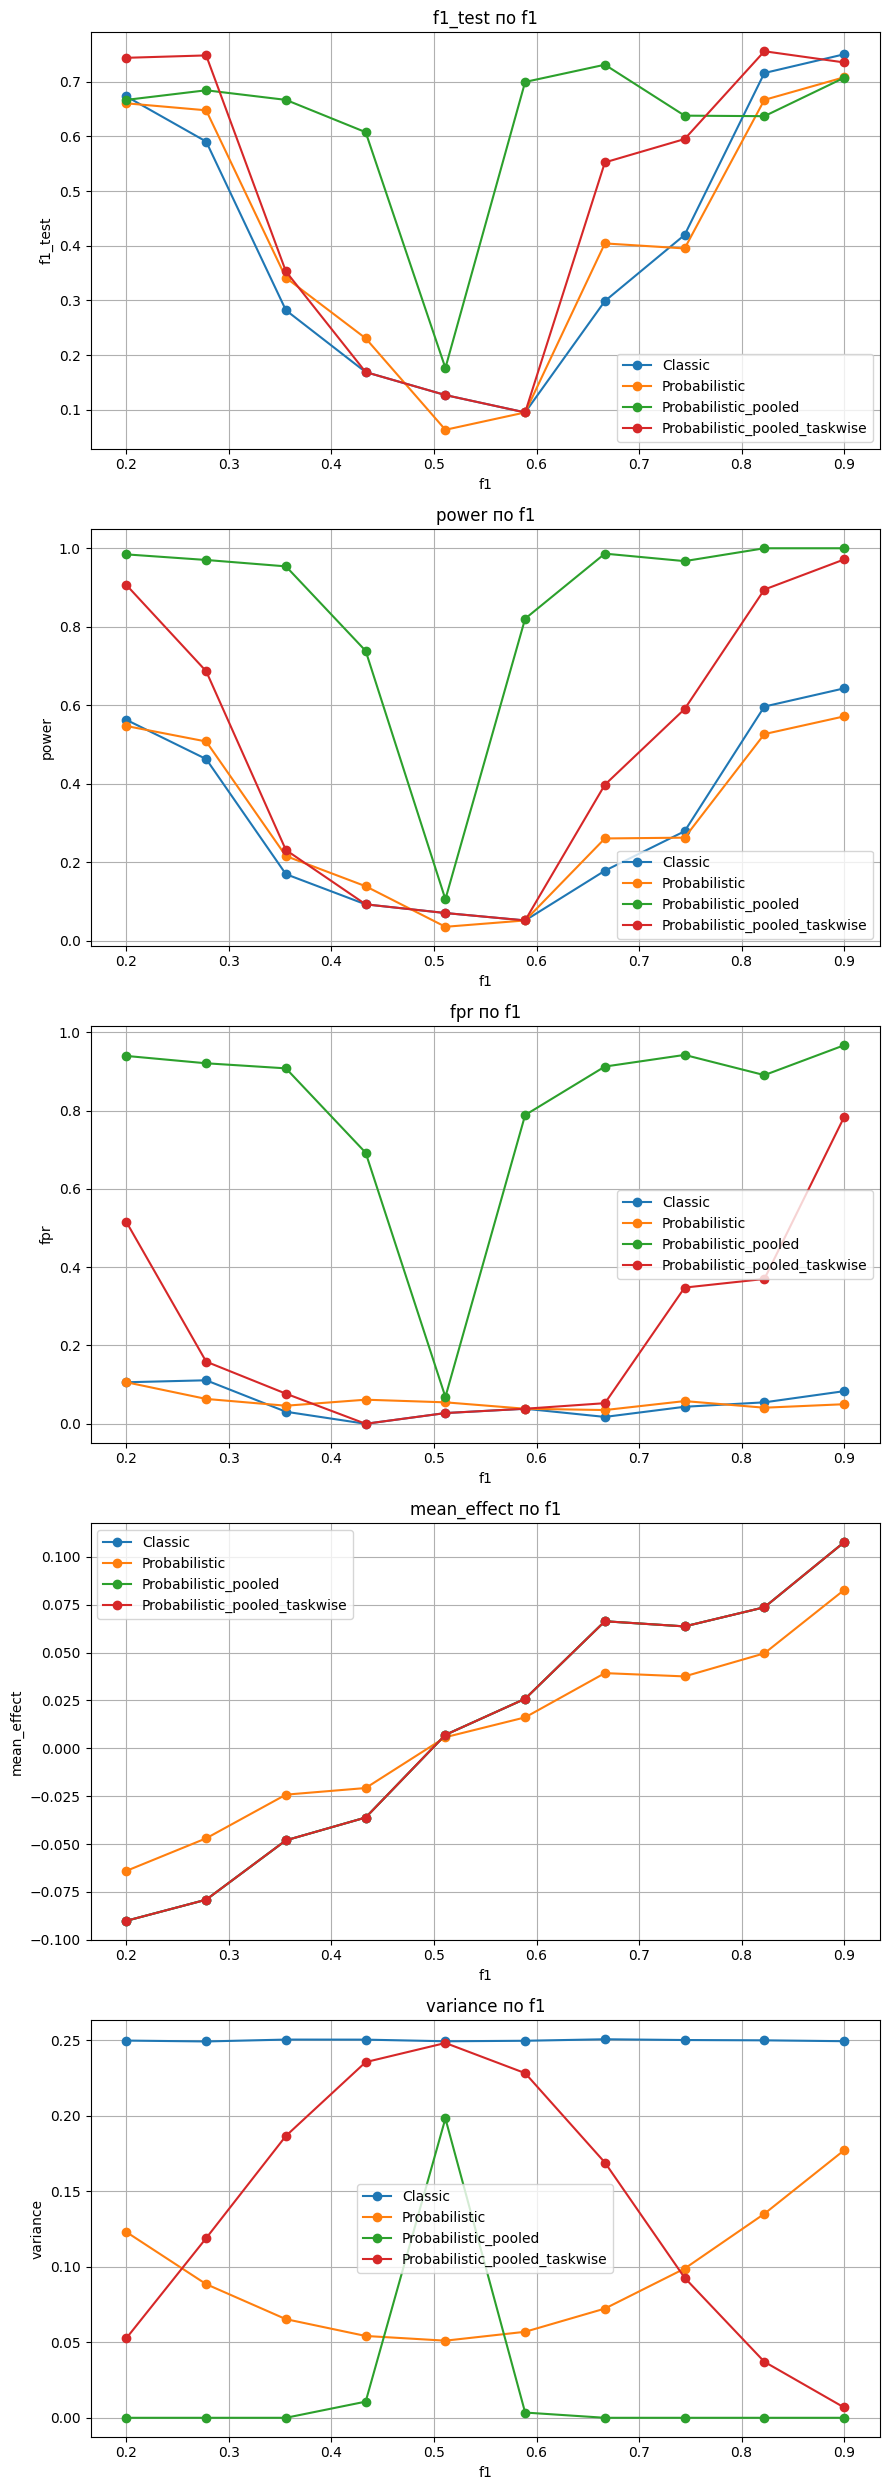

,f1,mean_f1_assessor,mean_prec_assessor,mean_rec_assessor,mean_fpr_assessor,method,f1_test,power,fpr,variance,mean_effect
0,0.200000,0.197408,0.197275,0.197667,0.802266,classic,0.672897,0.562500,0.106061,2.497914e-01,-0.090128
1,0.200000,0.197408,0.197275,0.197667,0.802266,probabilistic,0.660377,0.546875,0.106061,1.229975e-01,-0.064026
2,0.200000,0.197408,0.197275,0.197667,0.802266,probabilistic_pooled,0.666667,0.984375,0.939394,2.972457e-32,-0.090128
3,0.200000,0.197408,0.197275,0.197667,0.802266,probabilistic_pooled_taskwise,0.743590,0.906250,0.515152,5.277031e-02,-0.090128
4,0.277778,0.279870,0.279279,0.280784,0.723619,classic,0.590476,0.462687,0.111111,2.492112e-01,-0.079103
5,0.277778,0.279870,0.279279,0.280784,0.723619,probabilistic,0.647619,0.507463,0.063492,8.849405e-02,-0.047026
6,0.277778,0.279870,0.279279,0.280784,0.723619,probabilistic_pooled,0.684211,0.970149,0.920635,3.510101e-16,-0.079103
7,0.277778,0.279870,0.279279,0.280784,0.723619,probabilistic_pooled_taskwise,0.747967,0.686567,0.158730,1.189669e-01,-0.079103
8,0.355556,0.358947,0.359458,0.358720,0.638211,classic,0.282051,0.169231,0.030769,2.504628e-01,-0.048077
9,0.355556,0.358947,0.359458,0.358720,0.638211,probabilistic,0.341463,0.215385,0.046154,6.531647e-02,-0.024205


In [16]:
display(widgets_ui)